In [1]:
import cosmopower as cp
import frb_cov as frb
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Load Emulators

In [2]:
bias_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/bias_sq_model")
power_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/pkmm_nonlin_model")


Define fiducial cosmology and initialise cosmo dictionary


In [3]:
sigma8 = 0.834  # fluctuation amplitude
h = 0.674       # Hubble constant
omegam = 0.3    # matter density parameter
omegab = 0.05   # baryon density parameter
omegade = 1.0 - omegam # DE density parameter
w0 = -1         # DE equation of state
wa = 0          # DE equation of state
ns = 0.963      # spectral index of primordial power spectrum
neff = 3.046    # effective number of relativistic degrees of freedom
mnu = 0         # Neutrino mass in eV
Tcmb0 = 2.725   
alpha_B = 0.1   # Horndeski braiding
alpha_M = 0.1   # Horndeski Planck mass running
log_TAGN = 7.8  # feedback parameter (Mead2020)
ks = 0.1        # screening scale for modified gravity
delta_gamma = 0. # is there EP breaking=?
keys = ['sigma_8', 'h', 'omega_m', 'omega_b', 'omega_de', 'w0', 'wa',
        'ns', 'neff', 'm_nu', 'Tcmb0', 'alpha_B', 'alpha_M', 'logTAGN', 'ks', 'delta_gamma']
values = [sigma8, h, omegam, omegab, omegade,
          w0, wa,  ns, neff, mnu, Tcmb0, alpha_B, alpha_M, log_TAGN, ks, delta_gamma]
cosmo = dict(zip(keys, values))

Prepare FRB SAMPLE and read from different catalogues.

In [4]:
file_paths = ['./../data/FRBCat_arXiv2307.03344.csv']
ra_labels = ['RA (FRB)', 'ra (deg)']
dec_labels = ['Dec (FRB)', 'dec (deg)']
redshift_labels = ['z (host)', 'redshift', 'z_gal']
DM_obs_labels = ['DM (pc/cm3)',"dm", 'DM_obs']
DM_MW_labels = ['DM_ISM',"dm_milky_way", 'DM_MW']

ra = [] # RA
dec = [] # DEC
zet = [] # redshift
DM_obs = [] # Observed DM
DM_MW = [] # MW DM
frb_id = [] # ID of FRB
for file_path in file_paths:
    df = pd.read_csv(file_path)
    for keys in ra_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                ra.append(i_aux)
        except:
            continue
    for keys in dec_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                dec.append(i_aux)
        except:
            continue
    for keys in DM_obs_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_obs.append(i_aux)
        except:
            continue
    for keys in redshift_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                zet.append(i_aux)
        except:
            continue
    for keys in DM_MW_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_MW.append(i_aux)
        except:
            continue
ra = np.array(ra)
dec = np.array(dec)
DM_obs = np.array(DM_obs)
DM_MW = np.array(DM_MW)
zet = np.array(zet)
for i_ra, val_ra in enumerate(ra):
    if ":" in val_ra:
        ra[i_ra] = coord.Angle(val_ra, unit=units.degree)
for i_dec, val_dec in enumerate(dec):
    if ":" in val_dec:
        dec[i_dec] = coord.Angle(val_dec, unit=units.degree)

# Convert angles
ra = coord.Angle(ra, unit=units.degree)
dec = coord.Angle(dec, unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian*np.pi
n_with_host = len(zet)
z = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]

z[-1] = 1.5
#Compute pairwise distance on the sky between FRBs
delta_theta = np.zeros((n_with_host, n_with_host))
for i in range(n_with_host):
    for j in range(n_with_host):
        if (i != j):
            delta_theta[i, j] = np.arccos(np.sin(
                ra[i])*np.sin(ra[j]) + np.cos(ra[i])*np.cos(ra[j])*np.cos(dec[i] - dec[j]))


Construct the covariance passing the comsology, the electron bias and matter power spectrum emulator, the redshifts of the FRBs, their pairwise separation and for flatsky

0.844236513368437
0.8440415058103657
0.8443760810526867
0.8440661347446535
0.8443632306263014
0.8441067660755285
0.8443392307403882
0.8441570573690516
0.844305016037151
0.8442104994630543
0.8442614352701597
0.8440365840960473
0.8443786490130702
0.8440514053037589
0.844370915879496
0.844085197773504
0.8443523680230685
0.844131335416442
0.844323332588545
0.8441841322412469
0.8442840597548363
0.8441440297429862
0.8440385536065539
0.8442343293153075
0.8440508680736978
0.844225219019333
0.8440718728622578
0.8442084300578271
0.8440989124481402
0.8441861417946827
0.8441288753669729
0.8441585893908786
0.8440360927493947
0.8442361498680614
0.8440435033532504
0.8442306674713254
0.8440603995881231
0.8442176173809743
0.8440850708669562
0.8441978616418163
0.8441135508079077
0.8441728208459546
0.8443144466978814
0.8442386974215664
0.844377621398579
0.8442478077175409
0.8443711961853863
0.8442633471508294
0.8443599967576247
0.8442823495301888
0.8443440613644374
0.8443039070109931
0.8443249863847695
0

/opt/anaconda3/envs/frb_cat_env/lib/python3.12/site-packages/frb_cov/base.py:100: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  self.DM[z_idx] = (integrate.quad(self.weight, 0,


0.8631574877989301
0.8629332124913589
0.8631210881849363
0.86297800901247
0.8630762916638252
0.8676374298937789
0.8675888353256821
0.8676860244618756
0.8675942662230881
0.8676805935644697
0.8676035297056545
0.8676713300819032
0.867615804962252
0.8676590548253058
0.867630001579057
0.8676448582085008
0.8675877500442318
0.867687109743326
0.8675910182513565
0.8676838415362013
0.8675984697892157
0.867676389998342
0.8676093502587197
0.8676655095288381
0.8676227407079127
0.8676521190796451
0.8677427028583093
0.8676886284098722
0.8678090890426949
0.867694059307278
0.8678016697657945
0.8677033227898445
0.8677890147040089
0.8677155980464419
0.8677722451867609
0.8677325548625536
0.8677528508540652
0.8676875431284218
0.867810571671254
0.8676908113355465
0.8678061068965006
0.8676982628734057
0.8677959271750697
0.8677091433429096
0.8677810631093319
0.8677226356154141
0.8677627701012047
0.8451899701052433
0.8449800296417826
0.8454412668696533
0.8450016442246827
0.8454111328220849
0.8450393432159163
0

100%|██████████| 11/11 [00:01<00:00,  7.49it/s]


[[2.70265755e+03 5.77021385e+02 1.86051509e+02 5.75272915e+01
  2.16190295e+02 1.77247226e+03 2.78390685e+02 1.41543566e+03
  7.63803226e+02 2.97018648e+02 3.06043384e+02]
 [5.77021385e+02 1.46952549e+04 1.82656130e+02 0.00000000e+00
  2.89709780e+02 1.24455381e+03 3.91504529e+02 1.25618783e+03
  5.42267189e+02 3.89749142e+02 5.17794985e+02]
 [1.86051509e+02 1.82656130e+02 2.71873075e+04 1.19821726e+02
  2.50102876e+02 2.39581660e+02 1.84878296e+02 2.46403980e+02
  3.01352254e+02 2.89304038e+02 2.10812320e+02]
 [5.75272915e+01 0.00000000e+00 1.19821726e+02 6.65648758e+02
  9.50216168e+01 5.57737553e+01 6.87790874e+01 5.80517496e+01
  6.29426910e+01 8.67926478e+01 6.99484952e+01]
 [2.16190295e+02 2.89709780e+02 2.50102876e+02 9.50216168e+01
  3.15233056e+04 3.03694165e+02 6.44365027e+02 3.32978110e+02
  2.75123220e+02 1.10921273e+03 9.26240255e+02]
 [1.77247226e+03 1.24455381e+03 2.39581660e+02 5.57737553e+01
  3.03694165e+02 1.90701496e+04 3.56969128e+02 3.25638194e+03
  9.96585908e+02

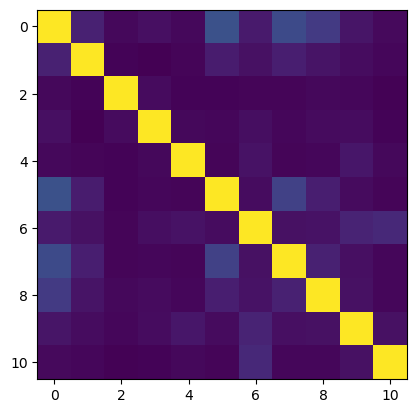

In [5]:
cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta,flat_sky=True)
corr = cov.covariance/(np.diag(cov.covariance)[:, None]*np.diag(cov.covariance)[None, :])**.5
plt.imshow(corr)
print(cov.covariance)


Construct the covariance passing the comsology, the electron bias and matter power spectrum emulator, the redshifts of the FRBs, their pairwise separation and for curved sky.

(100, 11, 11)


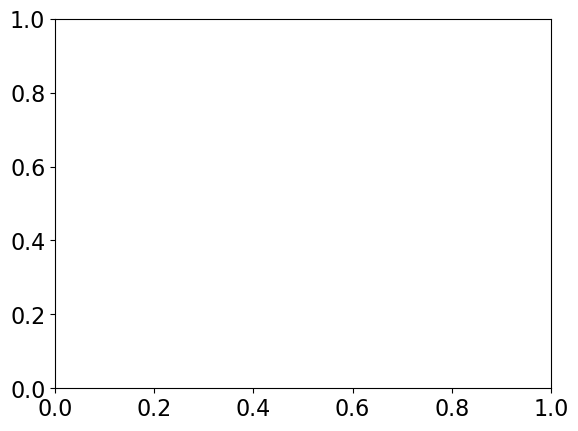

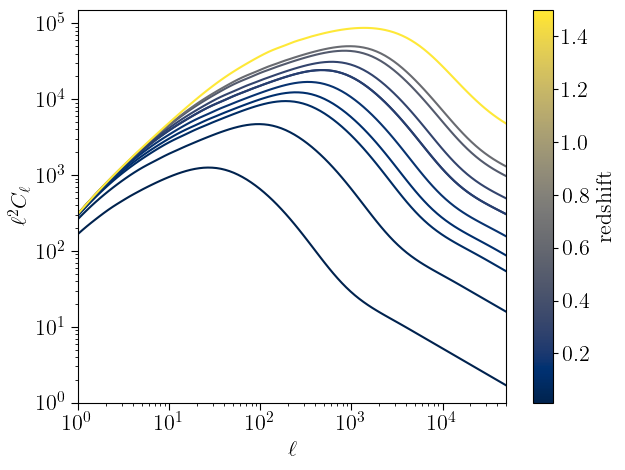

In [6]:
print(cov.C_ell.shape)

fontsi = 16
fontsi2 = 22

plt.tick_params(labelsize=fontsi)


plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('image', interpolation='none')


cmap = plt.get_cmap('cividis')
norm = plt.Normalize(vmin=z.min(), vmax=z.max())

# Plotting
fig, ax = plt.subplots()
# Add colorbar

i = 0
for param in z:
    plt.loglog(cov.ell, cov.ell**2*cov.C_ell[:, i,i], ls = "-",color=cmap(norm(param)))
    i+=1
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)

ax.set_xlabel(r"$\ell$", fontsize = fontsi)
ax.set_ylabel(r"$\ell^2 C_\ell$", fontsize = fontsi)

ax.tick_params(axis='both', which='major', labelsize=fontsi, length=5)  # Adjust as needed
cbar.ax.tick_params(labelsize=fontsi)  
cbar.set_label(r'$\mathrm{redshift}$', fontsize=fontsi)  # Set font size for colorbar label


plt.xlim(cov.ell[0],cov.ell[-1])
plt.tight_layout()
